# 快速开始 DeePMD-kit｜训练甲烷深度势能分子动力学模型

> 作者: YuZhi Zhang [zhangyz@dp.tech](mailto:zhangyz@dp.tech)
>
> 创建日期: 2023-03-26 19:13
>
> 最后一次修改: Haohui Que [quehaohui@dp.tech](mailto:quehaohui@dp.tech), 
>
> 最后一次修改时间: 2023-03-27 17:06
>
> 描述: 本教程可在 Bohrium Notebook 上直接运行。你可以点击界面上方蓝色按钮 `开始连接`，选择 `bohrium-notebook` 镜像及 `c8_m16_cpu` 节点配置，稍等片刻即可运行。
> 如您遇到任何问题，请联系 [bohrium@dp.tech](mailto:bohrium@dp.tech) 。
>
> 共享协议: 本作品采用[知识共享署名-非商业性使用-相同方式共享 4.0 国际许可协议](https://creativecommons.org/licenses/by-nc-sa/4.0/)进行许可。

## 目标

> **掌握使用 DeePMD-kit 建立深度势能分子动力学模型的范式周期，并跟随完整案例学习如何应用于分子动力学任务。**

在学习本教程后，你将能够：

* 了解 DeePMD-kit 训练所需的数据格式及运行脚本
* 训练、冻结、测试 DeePMD-kit 模型
* 在分子动力学软件 Lammps 中调用 DeePMD-kit 进行计算。

**阅读该教程【最多】约需 20 分钟，让我们开始吧！**

## 目录

* [背景](#background)
* [实践](#practice)
    * [1. 数据准备](#dataprepare)
    * [2. 准备输入脚本](#inputscript)
    * [3. 训练模型](#train)
    * [4. 冻结模型](#freeze)
    * [5. 测试模型](#test)
    * [6. 使用 Lammps 进行 MD 计算](#lammpsmd)
* * [参考](#references)

## 背景 <a id ='background'></a>

本教程将以气态甲烷分子为例，介绍DeePMD-kit的基本用法。建议使用[DeePMD-kit的文档](https://docs.deepmodeling.org/projects/deepmd/en/master/index.html)作为完整的参考。

Deep Potential (DP) 模型是使用 DeePMD-kit 包（v2.1.5）生成的。

训练数据使用名为dpdata（v0.2.14）的工具转换成DeePMD-kit格式。

有关dpdata和DeePMD-kit安装和执行的详细信息，请参阅[DeepModeling GitHub](https://github.com/deepmodeling)。

## 实践 <a id ='practice'></a>

### 1 数据准备 <a id ='dataprepare'></a>

我们已经为您准备了 $CH_4$ 的初始数据，并将其放置在文件夹`colombo-academy-tutorials/DeePMD-kit/00.data`中。

让我们通过 git 获取本教程所需的数据。获取的数据将放置于 `colombo-academy-tutorials` 目录下。

In [1]:
! if ! [ -e colombo-academy-tutorials ];then git clone https://gitee.com/deepmodeling/colombo-academy-tutorials.git;fi;

Cloning into 'colombo-academy-tutorials'...
remote: Enumerating objects: 7164, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 7164 (delta 78), reused 71 (delta 32), pack-reused 6990
Receiving objects: 100% (7164/7164), 45.31 MiB | 3.87 MiB/s, done.
Resolving deltas: 100% (3378/3378), done.
Updating files: 100% (185/185), done.


文件夹 `abacus_md` 是通过使用 ABACUS 进行从头算分子动力学（AIMD）获得的。有关 ABACUS 的详细说明可以在其[文档](https://abacus.deepmodeling.com/en/latest/)中找到。

In [2]:
# 查看 abacus_md 文件夹下的文件
import os

# 获取当前位置的根路径
prefix_path = os.getcwd()
# os.chdir()用于改变当前工作目录到指定的路径。
# os.path.join() 指定路径为 ‘当前路径/colombo-academy-tutorials/DeePMD-kit/00.data’。
os.chdir(os.path.join(prefix_path, "colombo-academy-tutorials", "DeePMD-kit", "00.data"))
# os.listdir() 列出 abacus 文件下的目录
os.listdir("abacus_md")

['C_ONCV_PBE-1.2.upf',
 'C_gga_6au_100Ry_2s2p1d.orb',
 'H_ONCV_PBE-1.2.upf',
 'H_gga_6au_100Ry_2s1p.orb',
 'INPUT',
 'KPT',
 'OUT.ABACUS',
 'STRU']

DeePMD-kit的训练数据包含原子类型、模拟晶格、原子坐标、原子力、系统能量和维里量。具有此信息的分子系统的快照称为帧。数据系统包括许多共享相同原子数和原子类型的帧。例如，分子动力学轨迹可以转换为数据系统，其中每个时间步长对应于系统中的一帧。

我们提供了一个方便的工具dpdata，可以将由CP2K、Gaussian、Quantum-Espresso、ABACUS和LAMMPS产生的数据转换为DeePMD-kit的压缩格式。

接下来，*ab initio* Molecular Dynamics(AIMD) 的数据将被随机分成训练和验证数据。

In [3]:
import dpdata 
import numpy as np

# 消除警告
import warnings
warnings.filterwarnings('ignore')

# 读入 ABACUS/MD 格式的数据
data = dpdata.LabeledSystem('abacus_md', fmt = 'abacus/md') 
print('# 数据包含%d帧' % len(data))

# 随机选择40个索引作为验证集数据
index_validation = np.random.choice(201,size=40,replace=False)
# 其他索引作为训练集数据
index_training = list(set(range(201))-set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
# 将所有训练数据放入文件夹"training_data"中
data_training.to_deepmd_npy('training_data')
# 将所有验证数据放入文件夹"validation_data"中
data_validation.to_deepmd_npy('validation_data')

print('# 训练数据包含%d帧' % len(data_training)) 
print('# 验证数据包含%d帧' % len(data_validation))

# 数据包含201帧
# 训练数据包含161帧
# 验证数据包含40帧


可以看到，161个帧被选为训练数据，其他40个帧是验证数据。

DeePMD-kit 采用压缩数据格式。所有训练数据应首先转换为此格式，然后可以在DeePMD-kit中使用。该数据格式在DeePMD-kit 手册中有详细解释，可以在[DeePMD-kit Github](http://www.github.com/deepmodeling/deepmd-kit)中找到。

让我们来查看一下训练集。

In [4]:
! tree training_data

training_data
├── set.000
│   ├── box.npy
│   ├── coord.npy
│   ├── energy.npy
│   ├── force.npy
│   └── virial.npy
├── type.raw
└── type_map.raw

1 directory, 7 files


In [5]:
! cat training_data/type.raw 

0
0
0
0
1


这告诉我们这个例子中有5个原子，其中4个原子由类型"0"表示，1个原子由类型"1"表示。有时需要将整数类型映射到原子名称。映射可以通过文件`type_map.raw`给出。

In [6]:
! cat training_data/type_map.raw 

H
C


这告诉我们类型“0”被命名为“H”，类型“1”被命名为“C”。

有关数据转换的更详细文档可以在[这里](https://docs.deepmodeling.org/projects/deepmd/en/master/data/data-conv.html)找到。

### 2 准备输入脚本 <a id ='inputscript'></a>

一旦数据准备完成，我们就可以进行训练。现在进入训练目录。

In [7]:
os.chdir(os.path.join(prefix_path, "colombo-academy-tutorials", "DeePMD-kit", "01.train"))

DeePMD-kit需要一个`json`格式的文件来指定训练参数。

在模型部分，指定了嵌入和拟合网络的参数。

```json
"model":{
    "type_map":    ["H", "C"],                 
    "descriptor":{
        "type":            "se_e2_a",          
        "rcut":            6.00,               
        "rcut_smth":       0.50,               
        "sel":             "auto",             
        "neuron":          [25, 50, 100],       
        "resnet_dt":       false,
        "axis_neuron":     16,                  
        "seed":            1,
        "_comment":        "that's all"
        },
    "fitting_net":{
        "neuron":          [240, 240, 240],    
        "resnet_dt":       true,
        "seed":            1,
        "_comment":        "that's all"
    },
    "_comment":    "that's all"'
},
```

部分参数的解释如下：

| 参数                | 解释                                                    |
| ------------------------ | ------------------------------------------------------------ |
| type_map                 | 每种原子的名称             |
| descriptor > type        | 描述类型                               |
| descriptor > rcut        | 截断半径                                          |
| descriptor > rcut_smth   | 平滑开始的位置                           |
| descriptor > sel         | 切割半径内第i种原子的最大数目 |
| descriptor > neuron      | 嵌入神经网络的大小             |
| descriptor > axis_neuron | G矩阵的子矩阵大小(嵌入矩阵) |
| fitting_net > neuron     | 拟合神经网络的大小               |

使用`se_e2_a`描述符来训练DP模型。`neurons`的参数将描述符和拟合网络的大小分别设置为[25, 50, 100]和[240, 240, 240]。本地环境中的组成部分会在从0.5到6 Å的范围内平滑地趋于零。

以下是指定学习率和损失函数的参数。

```json
    "learning_rate" :{
        "type":                "exp",
        "decay_steps":         50,
        "start_lr":            0.001,    
        "stop_lr":             3.51e-8,
        "_comment":            "that's all"
    },
    "loss" :{
        "type":                "ener",
        "start_pref_e":        0.02,
        "limit_pref_e":        1,
        "start_pref_f":        1000,
        "limit_pref_f":        1,
        "start_pref_v":        0,
        "limit_pref_v":        0,
        "_comment":            "that's all"
    },
```

在损失函数中，`pref_e`从0.02逐渐增加到1，`pref_f`从1000逐渐减小到1，这意味着力项在开始时占主导地位，而能量和压力项在最后变得重要。这种策略非常有效，并减少了总的训练时间。`pref_v`设置为0，表示训练过程中不包括压力数据。起始学习率、终止学习率和衰减步数分别设置为0.001、3.51e-8和50。模型训练10000步。

训练参数如下所示：

```json
    "training" : {
        "training_data": {
            "systems":            ["../00.data/training_data"],     
            "batch_size":         "auto",                       
            "_comment":           "that's all"
        },
        "validation_data":{
            "systems":            ["../00.data/validation_data/"],
            "batch_size":         "auto",               
            "numb_btch":          1,
            "_comment":           "that's all"
        },
        "numb_steps":             10000,                           
        "seed":                   10,
        "disp_file":              "lcurve.out",
        "disp_freq":              200,
        "save_freq":              10000,
        },
```

有关数据转换的更详细文档可以在[这里](https://docs.deepmodeling.org/projects/deepmd/en/master/data/data-conv.html)找到。

### 3 训练模型 <a id ='train'></a>

准备好训练脚本后，我们可以通过简单地运行DeePMD-kit来开始训练。

In [8]:
# ########## Time Warning: 5min ##########
! dp train input.json

2023-04-14 13:13:10.806065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 13:13:13.862244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 13:13:13.863464: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

屏幕上会显示数据系统的信息，例如：

```
DEEPMD INFO    -----------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: training     ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO               ../00.data/training_data       5       7      23  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
DEEPMD INFO    ---Summary of DataSystem: validation   ----------------------------------
DEEPMD INFO    found 1 system(s):
DEEPMD INFO                                 system  natoms  bch_sz   n_bch   prob  pbc
DEEPMD INFO             ../00.data/validation_data       5       7       5  1.000    T
DEEPMD INFO    -------------------------------------------------------------------------
```

以及该训练的起始和最终学习率：

```
DEEPMD INFO    start training at lr 1.00e-03 (== 1.00e-03), decay_step 50, decay_rate 0.950006, final lr will be 3.51e-08
```

如果一切正常，您将看到每1000步打印的信息，例如：

```
DEEPMD INFO    batch     200 training time 6.04 s, testing time 0.02 s
DEEPMD INFO    batch     400 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     600 training time 4.80 s, testing time 0.02 s
DEEPMD INFO    batch     800 training time 4.78 s, testing time 0.02 s
DEEPMD INFO    batch    1000 training time 4.77 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
DEEPMD INFO    batch    1200 training time 4.47 s, testing time 0.02 s
DEEPMD INFO    batch    1400 training time 4.49 s, testing time 0.02 s
DEEPMD INFO    batch    1600 training time 4.45 s, testing time 0.02 s
DEEPMD INFO    batch    1800 training time 4.44 s, testing time 0.02 s
DEEPMD INFO    batch    2000 training time 4.46 s, testing time 0.02 s
DEEPMD INFO    saved checkpoint model.ckpt
```

它们显示了训练和测试时间计数。在第1000批结束时，模型将保存在Tensorflow的checkpoint文件`model.ckpt`中。同时，训练和测试误差将在文件`lcurve.out`中呈现。

该文件包含8列，从左到右依次是训练步数、验证损失、训练损失、能量的均方根（RMS）验证误差、能量的RMS训练误差、力的RMS验证误差、力的RMS训练误差和学习率。能量的RMS误差（RMSE）通过系统中原子的数量进行归一化。

```
head -n 2 lcurve.out
#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      2.02e+01    1.51e+01      1.37e-01    1.41e-01      6.40e-01    4.79e-01    1.0e-03
```

和

```
$ tail -n 2 lcurve.out
   9800      2.45e-02    4.02e-02      3.20e-04    3.88e-04      2.40e-02    3.94e-02    4.3e-08
  10000      4.60e-02    3.76e-02      8.65e-04    5.35e-04      4.52e-02    3.69e-02    3.5e-08
```

第4、5和6、7卷分别呈现能量和力的训练和测试误差。

In [9]:
! head -n 2 lcurve.out && tail -n 2 lcurve.out

#  step      rmse_val    rmse_trn    rmse_e_val  rmse_e_trn    rmse_f_val  rmse_f_trn         lr
      0      1.89e+01    1.50e+01      1.38e-01    1.41e-01      5.98e-01    4.75e-01    1.0e-03
   9800      5.22e-02    2.70e-02      1.03e-03    7.02e-04      5.10e-02    2.64e-02    4.3e-08
  10000      4.50e-02    5.54e-02      5.23e-04    1.11e-03      4.42e-02    5.44e-02    3.5e-08


可以可视化损失函数来监控训练过程。

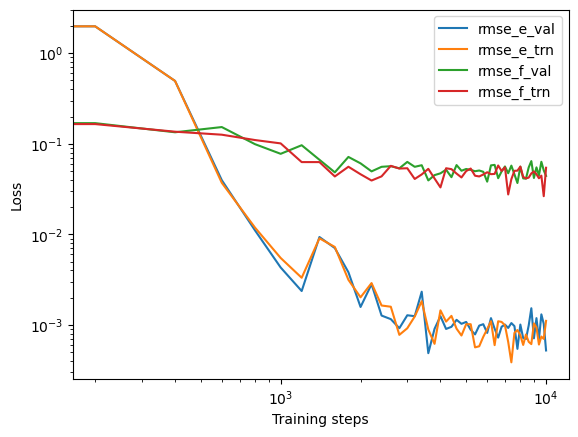

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

with open("lcurve.out") as f:
    headers = f.readline().split()[1:]
lcurve = pd.DataFrame(np.loadtxt("lcurve.out"), columns =  headers    )
legends = ["rmse_e_val", "rmse_e_trn", "rmse_f_val" , "rmse_f_trn" ]

for legend in legends:
    plt.loglog(lcurve["step"], lcurve[legend], label = legend )
plt.legend()
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

### 4 冻结模型 <a id ='freeze'></a>

在训练结束时，应该将保存在TensorFlow的checkpoint文件中的模型参数冻结为一个模型文件，通常以扩展名.pb结束。只需执行以下命令：

In [11]:
! dp freeze -o graph.pb

2023-04-14 13:16:11.308706: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 13:16:12.505293: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 13:16:12.505386: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

它将在当前目录中输出一个名为`graph.pb`的模型文件。

### 5 测试模型 <a id ='test'></a>

我们可以通过运行以下命令来检查训练模型的效果：

In [12]:
! dp test -m graph.pb -s ../00.data/validation_data

2023-04-14 13:16:18.143839: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 13:16:19.357550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 13:16:19.357663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

也可以计算预测数据和原始数据之间的相关性。

In [13]:
import dpdata
training_systems = dpdata.LabeledSystem("../00.data/training_data", fmt = "deepmd/npy")

In [14]:
predict = training_systems.predict("graph.pb")

2023-04-14 13:16:24.030142: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 13:16:25.275522: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 13:16:25.275663: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: N

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2023-04-14 13:16:27.054583: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: /usr/lib/x86_64-linux-gnu/libcuda.so.1: file too short; LD_LIBRARY_PATH: /usr/mpi/gcc/openmpi-4.1.0rc5/lib:/usr/local/nccl-rdma-sharp-plugins/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-04-14 13:16:27.054630: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]

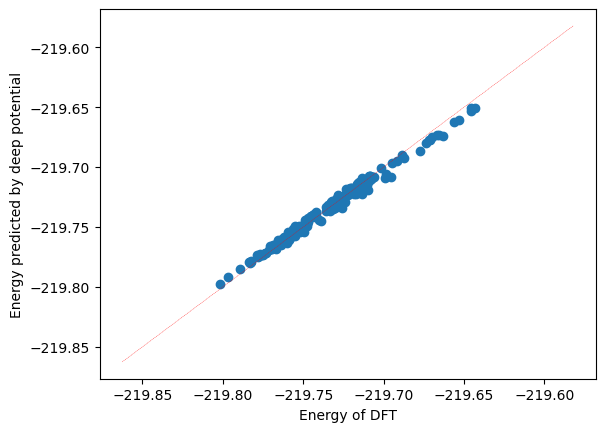

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(training_systems["energies"], predict["energies"])

x_range = np.linspace(plt.xlim()[0], plt.xlim()[1])

plt.plot(x_range, x_range, "r--", linewidth = 0.25)
plt.xlabel("Energy of DFT")
plt.ylabel("Energy predicted by deep potential")
plt.plot()

### 6 使用 Lammps 进行 MD 计算 <a id ='lammpsmd'></a>

该模型可以驱动LAMMPS中的分子动力学模拟。

In [16]:
! cd ../02.lmp && cp ../01.train/graph.pb ./ && ls

conf.lmp  graph.pb  in.lammps


! cd ../02.lmp && cp ../01.train/graph.pb ./ && lmp -i in.lammps这里的`conf.lmp`给出了气相甲烷分子动力学模拟的初始构型，文件`in.lammps`是LAMMPS的输入脚本。你可以检查`in.lammps`，可以发现它是一个相当标准的LAMMPS分子动力学模拟输入文件，只有两行例外：

```
pair_style  deepmd graph.pb
pair_coeff  * *
```

其中调用了 deepmd 的 pair_style，提供了模型文件 `graph.pb`，这意味着原子间相互作用将由存储在文件`graph.pb`中的 DP 模型进行计算。

在具有兼容版本的 LAMMPS 的环境中，可以通过以下命令执行深度势分子动力学模拟：

```bash
lmp -i input.lammps
```

In [ ]:
! cd ../02.lmp && cp ../01.train/graph.pb ./ && lmp -i in.lammps

## 参考 <a id ='references'></a>

1. https://docs.deepmodeling.com/projects/deepmd/en/master/index.html
2. https://github.com/deepmodeling/deepmd-kit 

<a href="https://bohrium.dp.tech/notebook/5e20dd12c8524fa38c1dafec5e2050c5" target="_blank"><img src="https://cdn.dp.tech/bohrium/web/static/images/open-in-bohrium.svg" alt="Open In Bohrium"/></a>